In [1]:
import matplotlib as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np
import pandas as pd

In [2]:
south_head = pd.read_csv("south_head.csv")
south_head

,,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,35-39 years,40-44 years,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85-89 years,90 years and over
0,Male,3,6,6,12,9,3,9,9,6,6,15,6,3,6,3,3,0,0,0
1,Female,6,0,3,6,3,6,3,9,3,6,9,6,9,3,3,3,0,0,0
2,Total,15,3,12,15,15,12,9,18,9,12,21,12,12,12,6,0,0,0,0


In [3]:
with pm.Model() as model_dirac:
    numpy_data = south_head.to_numpy()[:,1:]
    num_vars = 19*2

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)
    
    for i in range(19):
        pm.DiracDelta(f'obs_male_{i}_1', pt.tensor.le(x[i], numpy_data[0,i]+2), observed=True)
        if(numpy_data[0,i]>0):
            pm.DiracDelta(f'obs_male_{i}_2', pt.tensor.le(numpy_data[0,i]-2,x[i]), observed=True)
                
        pm.DiracDelta(f'obs_female_{i+19}_1', pt.tensor.le(x[i+19], numpy_data[1,i]+2), observed=True)
        if(numpy_data[1,i]>0):
            pm.DiracDelta(f'obs_female_{i+19}_2', pt.tensor.le(numpy_data[1,i]-2,x[i+19]), observed=True)
            
        pm.DiracDelta(f'obs_total_{i}_1', pt.tensor.le(x[i+19] + x[i], numpy_data[2,i]+2), observed=True)
        if(numpy_data[2,i]>0):
            pm.DiracDelta(f'obs_total_{i}_2', pt.tensor.le(numpy_data[2,i]-2, x[i+19] + x[i]), observed=True)

In [4]:
# sampling
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000, # a lot of tunning steps
        chains=4,
        initvals={'x': [5,4,7,11,9,4,7,7,6,8,15,6,1,8,2,1,1,0,1,8,0,3,5,5,7,3,10,1,5,8,4,11,4,5,1,1,2,1]} # we must provide a satisfying initial state, otherwise it does not work...
    ) 

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 61 seconds.
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (38), generating only 20 plots
  warnings.warn(


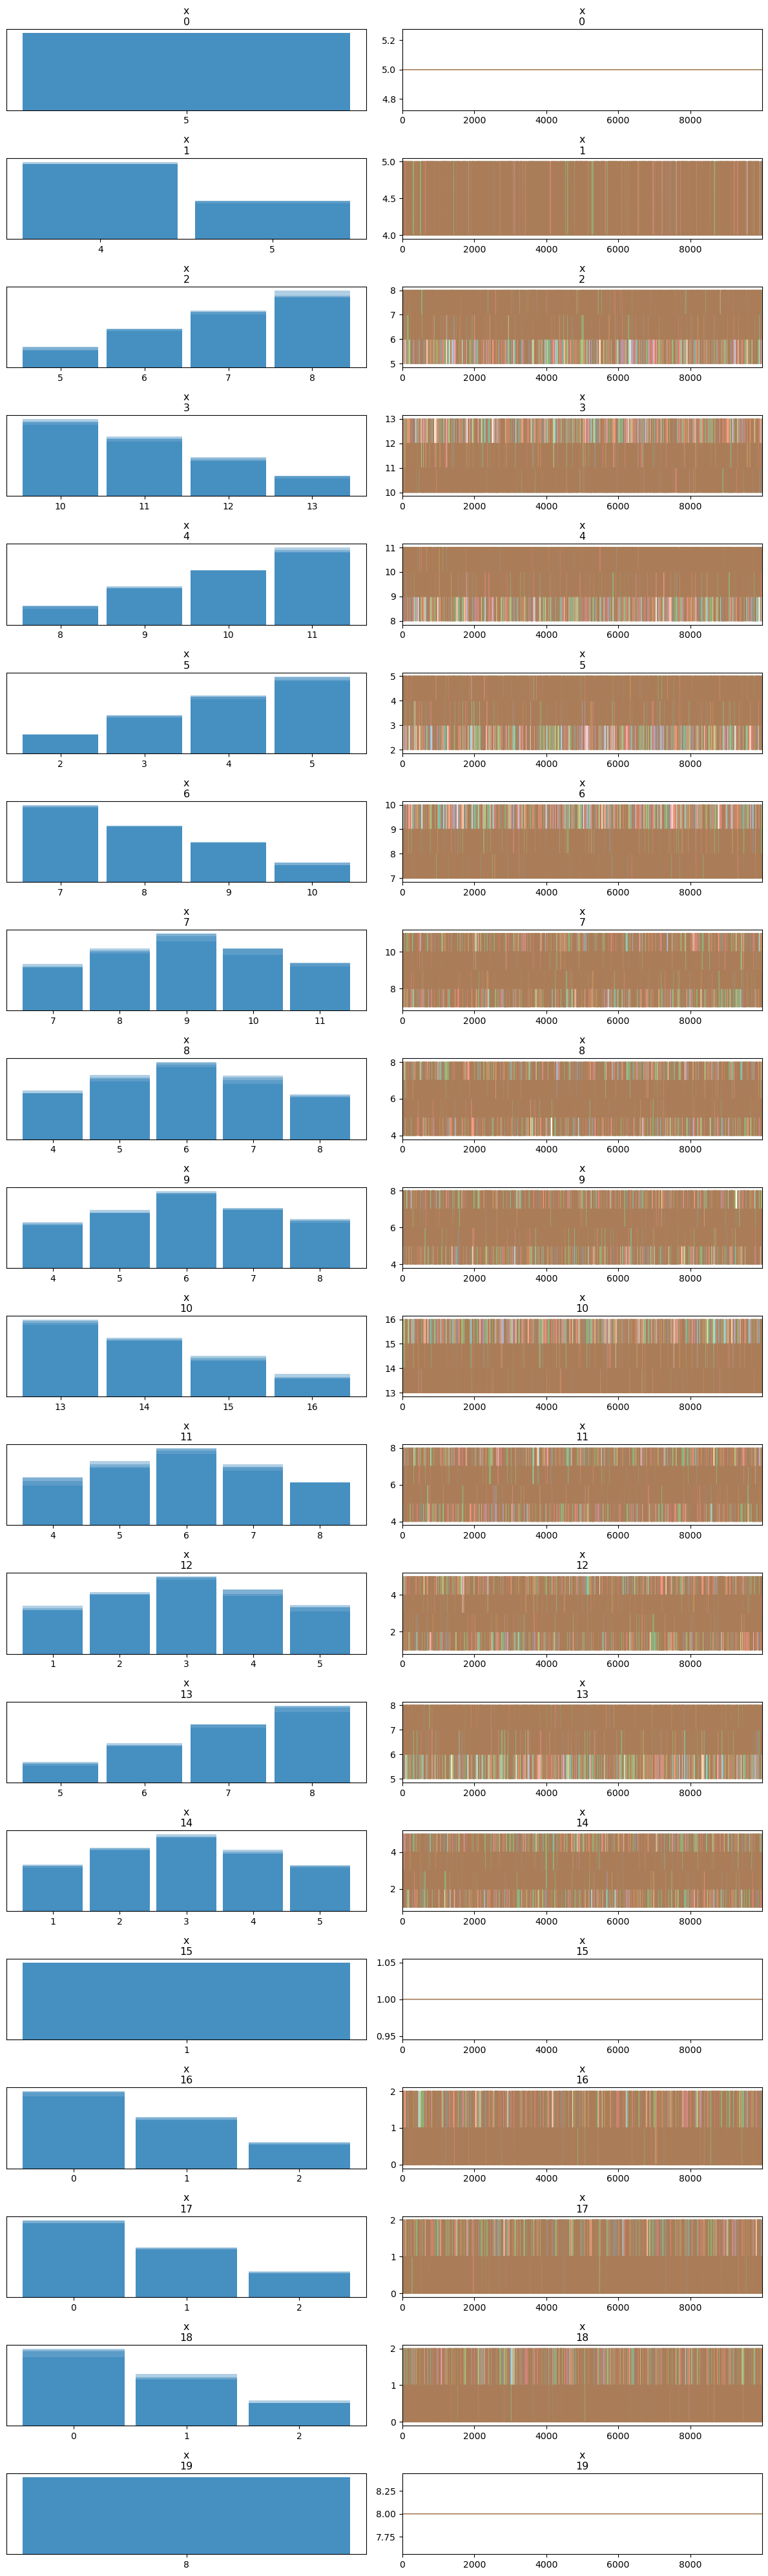

In [5]:
pm.plot_trace(trace, var_names=['x'] , combined=False, compact=False);
plt.pyplot.savefig('plot_pymc.png',dpi=150);